In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


In [2]:
nyc_data=pd.read_csv("nyc_data.csv")

In [3]:
nyc_data

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...,...
2187,12/27/2020,685.915026,0,0,0,2.89,38.674
2188,12/28/2020,998.051170,0,0,0,8.83,166.712
2189,12/29/2020,847.123399,0,0,0,3.48,161.865
2190,12/30/2020,857.521043,0,0,0,5.97,179.634


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

 
data = nyc_data   
features = data[['Easter', 'Thanksgiving', 'Christmas', 'Temperature', 'Marketing']]
target = data['Demand']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)   
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))  

 
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X, y = create_dataset(features_scaled, target_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)     


X_train shape: (1748, 7, 5)
y_train shape: (1748, 1)


In [5]:
X_train.shape

(1748, 7, 5)

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

Epoch 1/100
55/55 [==============================] - 3s 5ms/step - loss: 0.0406
Epoch 2/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0186
Epoch 3/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 4/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 5/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 6/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 7/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 8/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 9/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 10/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 11/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 12/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0176
Epoch 13/100
55/55 [=================

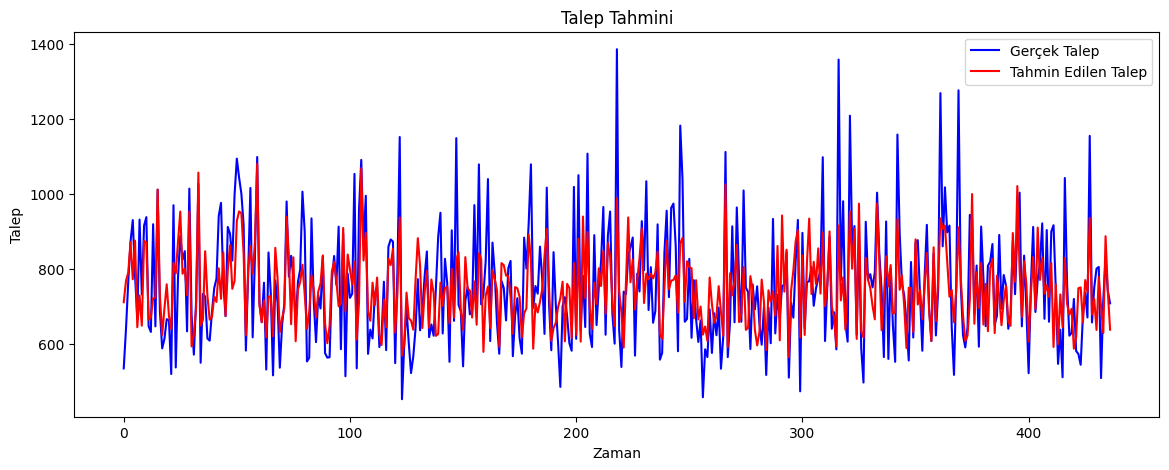

In [10]:
 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  

 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)
y_pred = model.predict(X_test)

 
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

 
plt.figure(figsize=(14,5))
plt.plot(y_test_rescaled, color='blue', label='Gerçek Talep')
plt.plot(y_pred_rescaled, color='red', label='Tahmin Edilen Talep')
plt.title('Talep Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Talep')
plt.legend()
plt.show()

In [11]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [12]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  
        return self.fc(lstm_out)

input_size = X_train.shape[2]  
hidden_size = 50
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()   
    optimizer.zero_grad()   
    outputs = model(X_train_tensor)   
    loss = criterion(outputs, y_train_tensor)   
    loss.backward()  
    optimizer.step()   

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/1000], Loss: 0.2076
Epoch [20/1000], Loss: 0.1954
Epoch [30/1000], Loss: 0.1835
Epoch [40/1000], Loss: 0.1721
Epoch [50/1000], Loss: 0.1609
Epoch [60/1000], Loss: 0.1499
Epoch [70/1000], Loss: 0.1389
Epoch [80/1000], Loss: 0.1281
Epoch [90/1000], Loss: 0.1172
Epoch [100/1000], Loss: 0.1064
Epoch [110/1000], Loss: 0.0956
Epoch [120/1000], Loss: 0.0848
Epoch [130/1000], Loss: 0.0743
Epoch [140/1000], Loss: 0.0641
Epoch [150/1000], Loss: 0.0546
Epoch [160/1000], Loss: 0.0459
Epoch [170/1000], Loss: 0.0386
Epoch [180/1000], Loss: 0.0328
Epoch [190/1000], Loss: 0.0288
Epoch [200/1000], Loss: 0.0264
Epoch [210/1000], Loss: 0.0252
Epoch [220/1000], Loss: 0.0248
Epoch [230/1000], Loss: 0.0246
Epoch [240/1000], Loss: 0.0244
Epoch [250/1000], Loss: 0.0242
Epoch [260/1000], Loss: 0.0241
Epoch [270/1000], Loss: 0.0239
Epoch [280/1000], Loss: 0.0237
Epoch [290/1000], Loss: 0.0235
Epoch [300/1000], Loss: 0.0234
Epoch [310/1000], Loss: 0.0232
Epoch [320/1000], Loss: 0.0230
Epoch [330/1000],

In [14]:
model.eval()   
with torch.no_grad():
    test_outputs = model(X_test_tensor)
predictions = test_outputs.numpy()
print(predictions)

[[0.3031445 ]
 [0.37165877]
 [0.36171627]
 [0.34953752]
 [0.36321455]
 [0.42423126]
 [0.26845416]
 [0.36255398]
 [0.24509479]
 [0.37226704]
 [0.42096353]
 [0.28143767]
 [0.29459468]
 [0.3135673 ]
 [0.33496955]
 [0.57259434]
 [0.277599  ]
 [0.23507337]
 [0.26993403]
 [0.3429392 ]
 [0.27956292]
 [0.22104548]
 [0.3864816 ]
 [0.39419356]
 [0.4262555 ]
 [0.42647496]
 [0.38867244]
 [0.32141265]
 [0.33824906]
 [0.56437653]
 [0.23501603]
 [0.22927587]
 [0.27572778]
 [0.54704183]
 [0.2796643 ]
 [0.26372698]
 [0.4247838 ]
 [0.34277758]
 [0.2705857 ]
 [0.3022506 ]
 [0.3387833 ]
 [0.30591574]
 [0.36805147]
 [0.3699381 ]
 [0.35667118]
 [0.24984248]
 [0.35431567]
 [0.4361653 ]
 [0.41632628]
 [0.4128764 ]
 [0.52098113]
 [0.59805393]
 [0.4416    ]
 [0.39072084]
 [0.26218587]
 [0.4551361 ]
 [0.4254028 ]
 [0.35049614]
 [0.38840136]
 [0.523289  ]
 [0.30286476]
 [0.23850797]
 [0.3053539 ]
 [0.2731832 ]
 [0.33882514]
 [0.34400874]
 [0.23578082]
 [0.45033196]
 [0.40114918]
 [0.25017253]
 [0.25781977]
 [0.28

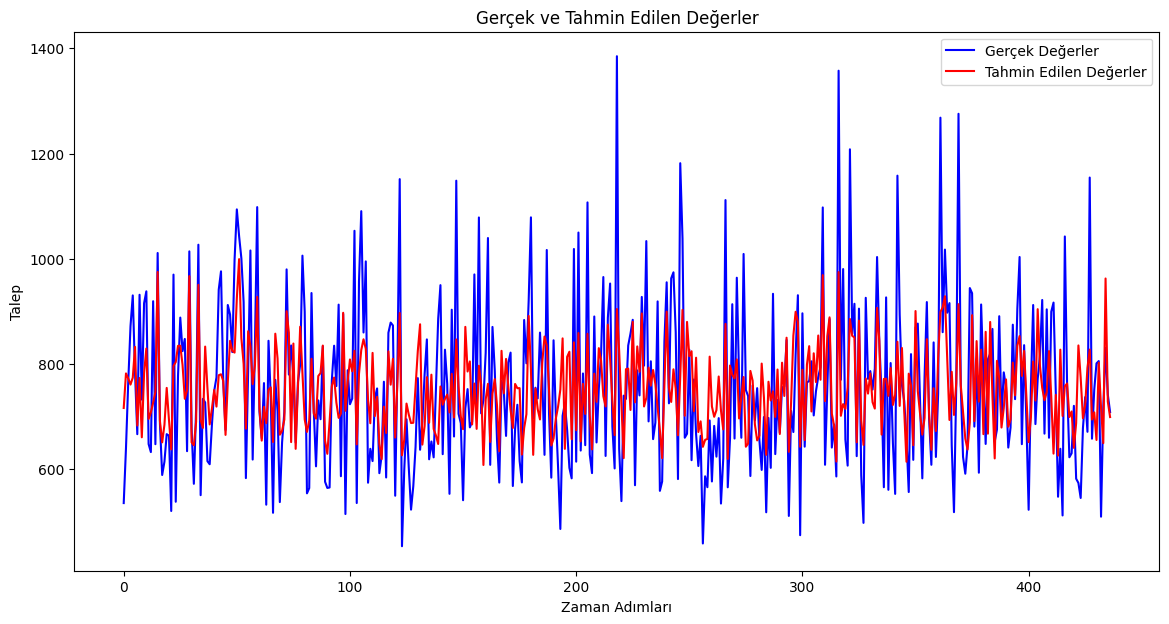

In [15]:
import matplotlib.pyplot as plt
 
y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())   
predictions_actual = scaler.inverse_transform(predictions)  

# Grafik oluşturma
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Gerçek Değerler', color='blue')
plt.plot(predictions_actual, label='Tahmin Edilen Değerler', color='red')
plt.title('Gerçek ve Tahmin Edilen Değerler')
plt.xlabel('Zaman Adımları')
plt.ylabel('Talep')
plt.legend()
plt.show()
